## Задание

1) Exploratory data analysis: поискать интересные фичи, интересные корреляции, распределения,

2) Генерация новых признаков

3) Эксперименты с алгоритмами бустинга, изученными на лекции

4) Выбор лучшей модели 

5) Отправка на платформу kaggle и результат на тестовых данных (оттуда можно скачать test.csv, sample_submission.csv, в репозиторий не добавлял, чтобы не увеличивать объём).

https://www.kaggle.com/c/sberbank-russian-housing-market/data

Помогут выполнить задание слайды с лекции 2, а также 2 семинарских ноутбука

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('train.csv', parse_dates=['timestamp'])
data = data.set_index('id')

Ставится задача по всем признакам предсказать целевую переменную `price_doc`. Более подробнную информацию о признаках можно найти в `data.txt`

In [3]:
data.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
id,,,,,,,,,,,,,,,,,,,,,
1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


### Обработка признаков 


Посмотрим, какие типы данных присутствуют в нашей выборке

In [4]:
ddf = data.dtypes.reset_index()
ddf.columns = ['Count columns', 'Type']
ddf.groupby('Type').count()

,Count columns
Type,
datetime64[ns],1
int64,156
float64,119
object,15


Посмотрим на корреляцию в данных

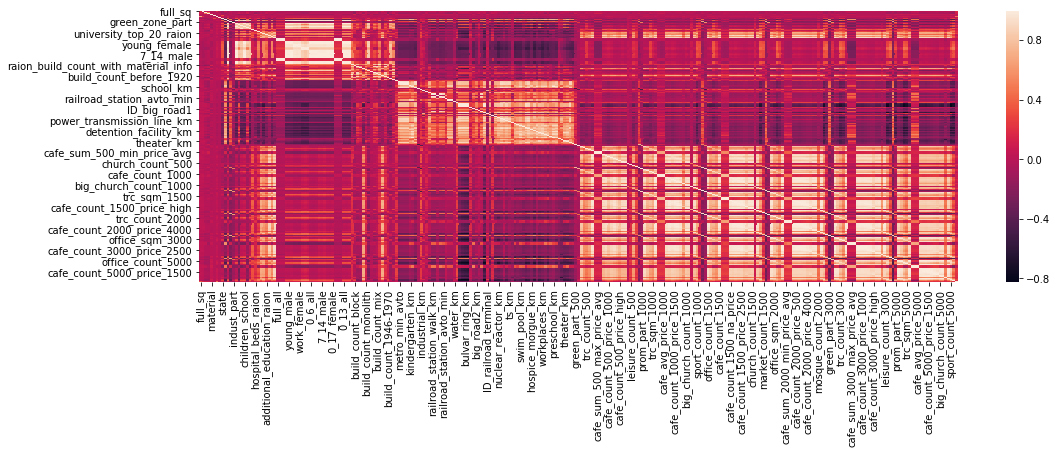

In [5]:
fig = plt.figure(figsize=(17, 5))
sns.heatmap(data.corr())

#### Обработка временных признаков

Комбинированный признак, отвечающий за время мы можем разделить на год, месяц и день недели.

In [6]:
data['year'] = data['timestamp'].apply(lambda x: x.year)
data['month'] = data['timestamp'].apply(lambda x: x.month)
data['day'] = data['timestamp'].apply(lambda x: x.day_name())
data = data.drop('timestamp', axis=1)

In [7]:
ddf = data.dtypes.reset_index()
ddf.columns = ['cols', 'Type']
ddf.groupby('Type').count()

,cols
Type,
int64,158
float64,119
object,16


### Обработка категориальных значений

In [8]:
ddf = data.dtypes.reset_index()
ddf.columns = ['cols', 'Type']

Категориальные признаки как правило имеют тип `'object'`. Поэтому достанем их и посмотрим глазами на них

In [9]:
cat_bin_columns = ddf[ddf.Type == 'object'].cols.values

In [10]:
cat_bin_columns

array(['product_type', 'sub_area', 'culture_objects_top_25',
       'thermal_power_plant_raion', 'incineration_raion',
       'oil_chemistry_raion', 'radiation_raion',
       'railroad_terminal_raion', 'big_market_raion',
       'nuclear_reactor_raion', 'detention_facility_raion', 'water_1line',
       'big_road1_1line', 'railroad_1line', 'ecology', 'day'],
      dtype=object)

In [11]:
data[cat_bin_columns].head()

,product_type,sub_area,culture_objects_top_25,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,water_1line,big_road1_1line,railroad_1line,ecology,day
id,,,,,,,,,,,,,,,,
1,Investment,Bibirevo,no,no,no,no,no,no,no,no,no,no,no,no,good,Saturday
2,Investment,Nagatinskij Zaton,yes,no,no,no,no,no,no,no,no,no,no,no,excellent,Tuesday
3,Investment,Tekstil'shhiki,no,no,no,no,yes,no,no,no,no,no,no,no,poor,Saturday
4,Investment,Mitino,no,no,no,no,no,no,no,no,no,no,no,no,good,Thursday
5,Investment,Basmannoe,no,no,no,no,yes,yes,no,no,no,no,no,yes,excellent,Monday


Как видно, среди выбранных признаков есть категориальные и бинарные. Разделим их, чтобы правильно анализировать

In [12]:
!pip install --user scikit-learn==0.21.2

In [13]:
cat_columns = ['product_type', 'sub_area', 'ecology', 'day']
bin_columns = list(set(cat_bin_columns) - set(cat_columns))

Категориальные признаки обработаем с помощью OneHotEncoder (get_dummies делает тоже самое)

In [14]:
data = pd.get_dummies(data, columns=cat_columns)

Бинарные признаки обработаем с помощью OrdinalEncoder

In [15]:
from sklearn.preprocessing import OrdinalEncoder

In [16]:
lbl = OrdinalEncoder()
lbl.fit(data[bin_columns])
data[bin_columns] = lbl.transform(data[bin_columns])

In [17]:
data[bin_columns].head()

,big_market_raion,radiation_raion,culture_objects_top_25,oil_chemistry_raion,big_road1_1line,incineration_raion,railroad_terminal_raion,thermal_power_plant_raion,detention_facility_raion,water_1line,railroad_1line,nuclear_reactor_raion
id,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [18]:
ddf = data.dtypes.reset_index()
ddf.columns = ['Count columns', 'Type']
ddf.groupby('Type').count()

,Count columns
Type,
uint8,160
int64,158
float64,131


### Разделение выборки на Train и Test

In [19]:
from sklearn.model_selection import train_test_split

Посмотрим на распределение целевой переменной

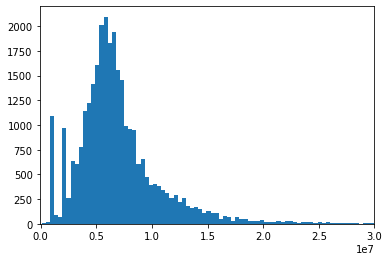

In [20]:
plt.hist(data['price_doc'], bins=300)
plt.xlim([-1e5, 3e7])
plt.show()

In [21]:
train_data, test_data = train_test_split(data, test_size=0.3,
                                          shuffle=True,
                                          random_state=42)
train_data = train_data.copy()
test_data = test_data.copy()

Посмотрим на распределение целевой переменной на train и test

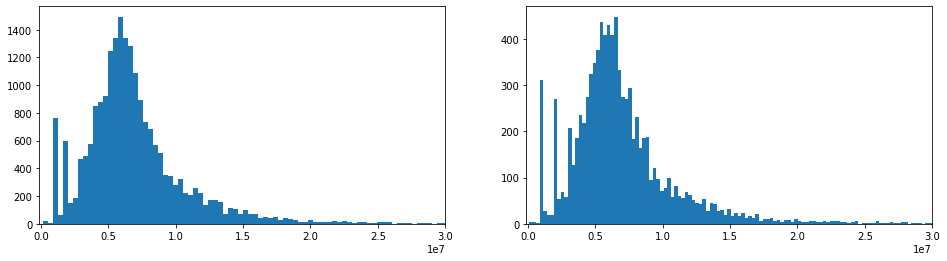

In [22]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.hist(train_data['price_doc'], bins=300)
plt.xlim([-1e5, 3e7])

plt.subplot(122)
plt.hist(test_data['price_doc'], bins=300)
plt.xlim([-1e5, 3e7])

plt.show()

In [23]:
y_train = train_data['price_doc']
X_train = train_data.drop('price_doc', axis=1)

y_test = test_data['price_doc']
X_test = test_data.drop('price_doc', axis=1)

### Пропущенные значения

Можно просто убрать все строчки, где есть пропущенные значения. Но это не совсем хорошо, можем потерять много данных

In [24]:
X_train.shape, X_train.dropna().shape, 

((21329, 448), (4211, 448))

Попробуем заполнить значения одним из 3 предложенных способов

In [25]:
null_vals = X_train.mean()

X_train = X_train.fillna(null_vals)
X_test = X_test.fillna(null_vals)

### Нормализация

In [26]:
from sklearn.preprocessing import (StandardScaler, Normalizer,
                                  MinMaxScaler, QuantileTransformer)

In [27]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Модель

In [28]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_log_error

rmsle = lambda y1, y2: np.sqrt(mean_squared_log_error(y1, y2))

In [29]:
reg = Ridge(alpha=100)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
y_pred[y_pred<=0] = 1e-8
rmsle(y_test, y_pred)

0.5447315211461836

In [30]:
from sklearn.ensemble import RandomForestRegressor

In [31]:
reg = RandomForestRegressor()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
rmsle(y_test, y_pred)

/home/maihes/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.47855403305181016

### Подбор параметров

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet

In [33]:
gs = GridSearchCV(estimator=ElasticNet(),
                  param_grid={'alpha': [0.1, 1, 10],
                              'l1_ratio': [0.01, 0.05, 0.1]},
                  scoring='neg_mean_squared_error', n_jobs=-1, cv=3)

In [34]:
gs.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0.1, 1, 10], 'l1_ratio': [0.01, 0.05, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [35]:
reg = gs.best_estimator_
reg.fit(X_train, y_train)

ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.1,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [36]:
y_pred = reg.predict(X_test)
rmsle(y_test, y_pred)

0.58004327719058